In [1]:
import sys 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import numpy as np
import math

sys.path.insert(1, "/home/paperspace/devinterp") # TODO fix path

from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct
from torch.utils.data import TensorDataset
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def train_one_batch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        break
    return train_loss

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    model.train()
    return test_loss / len(test_loader)


In [3]:
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(torch.tensor([0., 0.],dtype=torch.float32, requires_grad=True))
        self.powers = powers
    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x*multiplied
        return x

powers = torch.tensor([1, 2]) # w1 * w2^2
model = PolyModel(powers)
sigma = 0.25
lr = 0.0005
num_train_samples = 5000
num_test_samples = 1000
batch_size = num_train_samples
w_true = torch.zeros_like(powers)

x = torch.normal(0, 2, size=(num_train_samples,))
y = sigma * torch.normal(0, 1, size=(num_train_samples,))
train_data = TensorDataset(x, y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
rlct_estimates = []
test_loss = 0.
n_estimates = 50

def print_rlcts(SGNHT_config, SGLD_config):
    rlct_estimates_sgnht = []
    rlct_estimates_sgdl = []
    for _ in range(n_estimates):
        sgnht_sampler = Sampler(model, train_data, SGNHT_config)
        sgdl_sampler = Sampler(model, train_data, SGLD_config)
        rlct_estimate_sgnht = sgnht_sampler.sample(summary_fn=estimate_rlct)
        rlct_estimate_sgdl = sgdl_sampler.sample(summary_fn=estimate_rlct)
        if not math.isnan(rlct_estimate_sgnht):
            rlct_estimates_sgnht += [rlct_estimate_sgnht]
        if not math.isnan(rlct_estimate_sgdl):
            rlct_estimates_sgdl += [rlct_estimate_sgdl]
    plt.hist(rlct_estimates_sgnht, alpha = 0.5, label='sgnht')
    plt.hist(rlct_estimates_sgdl, alpha = 0.5, label='sgdl')
    plt.legend()
    plt.show()
    print(f'estimated rlct: sgnht: {np.mean(rlct_estimates_sgnht)}, sgdl: {np.mean(rlct_estimates_sgdl)}')




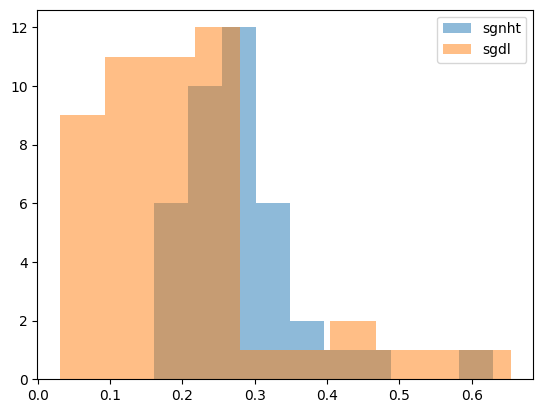

estimated rlct: sgnht: 0.28123458532186657, sgdl: 0.20561846613883972
right answer was 0.25


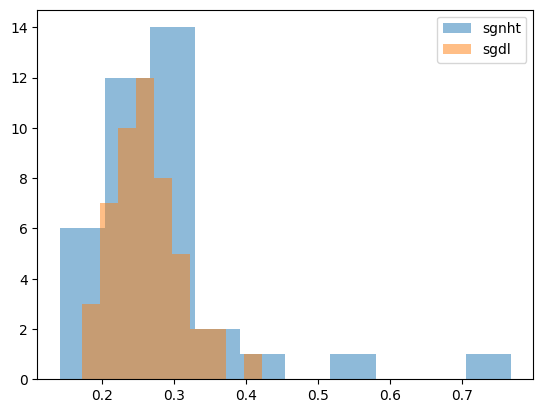

estimated rlct: sgnht: 0.2797463250321311, sgdl: 0.2629582941532135
right answer was 0.25


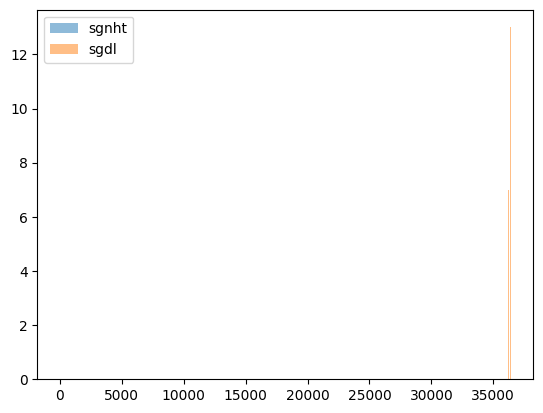

/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


estimated rlct: sgnht: nan, sgdl: 36336.34015625
right answer was 0.5


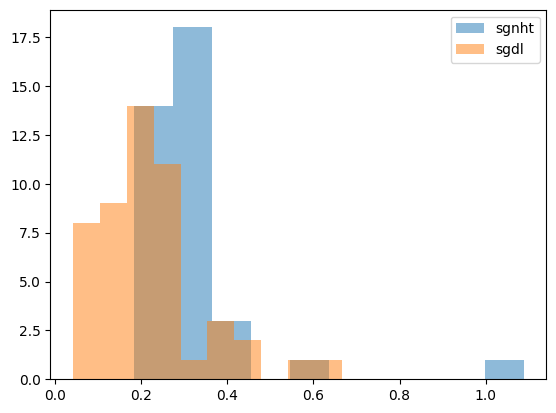

estimated rlct: sgnht: 0.31009077300896515, sgdl: 0.21572253450751305
right answer was 0.25


In [4]:
# Initialize sgnht sampler
SGNHT_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGNHT",
        lr=lr,
        diffusion_factor=0.01,
        bounding_box_size=1.,
        num_samples=len(train_data),
        batch_size = batch_size,
    ),
    num_chains=1,
    num_draws_per_chain=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    batch_size=batch_size,         
    criterion = 'mse_loss' 
)

SGLD_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGLD",
        lr=lr,
        noise_level=1.,
        elasticity=1.,
        bounding_box_size=1.,
        temperature='adaptive',
        num_samples=len(train_data),
    ),
    num_chains=1,
    num_draws_per_chain=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=batch_size,         
    criterion = 'mse_loss'
)
model.weights= nn.Parameter(torch.tensor([0., 0.],dtype=torch.float32, requires_grad=True))
right_answer = 0.25 # min(1/2*2, 1/1*2), as we have w1 * w2 ^ 2
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([2., 0.],dtype=torch.float32, requires_grad=True))
right_answer =  0.25 # 1/2*2,  as we are currently far away from the center but on the line where w2=0, so we should get the w2 singularity only
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([0., 3.],dtype=torch.float32, requires_grad=True))
right_answer =  0.5 # 1/2, as we are currently at w1=0, so we measure the rlct of the w1 singularity only
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')

model.weights= nn.Parameter(torch.tensor([.01, .01],dtype=torch.float32, requires_grad=True))
right_answer =  0.25 # min(1/2*2, 1/1*2), as the free energy estimate should still be right if we're not exactly at the singularity
print_rlcts(SGNHT_config, SGLD_config)
print(f'right answer was {right_answer}')


In [ ]:
# TODO what does a trajectory look like?